# House Prices - My Solution

This is my solution to the house prices competition on Kaggle! I will also be recreated another solution after I complete this submission.

## Import Libraries

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                              IsolationForest, RandomForestRegressor)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score, learning_curve)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import missingno as msno

warnings.filterwarnings('ignore')

# Load Data

Because we have so many features, I will also sort columns alphabetically to make it easier to find columns in my analysis. It is important to note that ID and SalePrice are our identifier and target columns respectively.

In [2]:
train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
train = pd.read_csv(train_path)
train = train.reindex(sorted(train.columns), axis=1)

test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"
test = pd.read_csv(test_path)
test = test.reindex(sorted(test.columns), axis=1)

descr_path = "/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt"

# Overview of Data

In [3]:
train

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706,0,...,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978,0,...,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486,0,...,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216,0,...,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655,0,...,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,NaN,3,1Fam,TA,No,0,0,...,WD,0,Pave,7,953,AllPub,0,1999,2000,2007
1456,2073,0,0,NaN,3,1Fam,TA,No,790,163,...,WD,0,Pave,7,1542,AllPub,349,1978,1988,2010
1457,1188,1152,0,NaN,4,1Fam,Gd,No,275,0,...,WD,0,Pave,9,1152,AllPub,0,1941,2006,2010
1458,1078,0,0,NaN,2,1Fam,TA,Mn,49,1029,...,WD,0,Pave,5,1078,AllPub,366,1950,1996,2010


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1460 non-null   int64  
 2   3SsnPorch      1460 non-null   int64  
 3   Alley          91 non-null     object 
 4   BedroomAbvGr   1460 non-null   int64  
 5   BldgType       1460 non-null   object 
 6   BsmtCond       1423 non-null   object 
 7   BsmtExposure   1422 non-null   object 
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtFinType1   1423 non-null   object 
 11  BsmtFinType2   1422 non-null   object 
 12  BsmtFullBath   1460 non-null   int64  
 13  BsmtHalfBath   1460 non-null   int64  
 14  BsmtQual       1423 non-null   object 
 15  BsmtUnfSF      1460 non-null   int64  
 16  CentralAir     1460 non-null   object 
 17  Condition1     1460 non-null   object 
 18  Conditio

In [5]:
# Open the file and iterate through each line
with open(descr_path, 'r') as file:
    for line in file:
        # Check if the line is not indented and not blank line
        if not line.startswith(' ') and line.strip():
            print(line.strip())  # Print the line, removing any leading/trailing whitespace

MSSubClass: Identifies the type of dwelling involved in the sale.
MSZoning: Identifies the general zoning classification of the sale.
LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet
Street: Type of road access to property
Alley: Type of alley access to property
LotShape: General shape of property
LandContour: Flatness of the property
Utilities: Type of utilities available
LotConfig: Lot configuration
LandSlope: Slope of property
Neighborhood: Physical locations within Ames city limits
Condition1: Proximity to various conditions
Condition2: Proximity to various conditions (if more than one is present)
BldgType: Type of dwelling
HouseStyle: Style of dwelling
OverallQual: Rates the overall material and finish of the house
OverallCond: Rates the overall condition of the house
YearBuilt: Original construction date
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
RoofStyle: Type of roof
RoofMatl: Roof material
Exte

In [6]:
train.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,...,6.099315,2.758904,180921.195890,15.060959,6.517808,1057.429452,94.244521,1971.267808,1984.865753,2007.815753
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,...,1.382997,40.177307,79442.502883,55.757415,1.625393,438.705324,125.338794,30.202904,20.645407,1.328095
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,...,5.000000,0.000000,129975.000000,0.000000,5.000000,795.750000,0.000000,1954.000000,1967.000000,2007.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,...,6.000000,0.000000,163000.000000,0.000000,6.000000,991.500000,0.000000,1973.000000,1994.000000,2008.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,...,7.000000,0.000000,214000.000000,0.000000,7.000000,1298.250000,168.000000,2000.000000,2004.000000,2009.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,...,10.000000,738.000000,755000.000000,480.000000,14.000000,6110.000000,857.000000,2010.000000,2010.000000,2010.000000


## Group numerical and categorical features

Unfortunately, we cannot simply look for numerical and string data. Many features have categories of numerical data. Ex: month sold should be treated as a categorical value rather than a numerical value.

Here are comparisons for discrete and continuous feature distributions.

<Axes: xlabel='YearBuilt', ylabel='Count'>

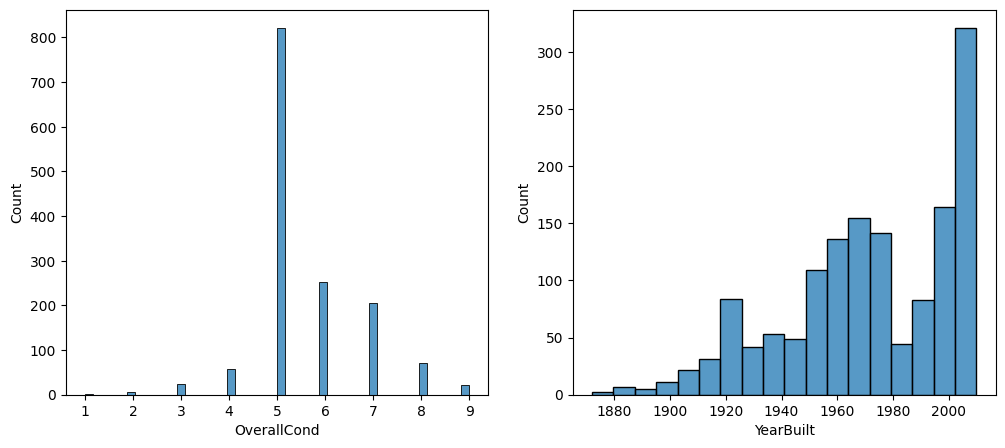

In [7]:
# Create a figure with two subplots aligned horizontally
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# First histogram for "OverallCond"
sns.histplot(train, x="OverallCond", ax=ax[0])

# Second histogram for "YearBuilt"
sns.histplot(train, x="YearBuilt", ax=ax[1])

It seems the project of discerning discrete from continuous numerical data is heavily debated on [stack overflow](https://stackoverflow.com/questions/35826912/what-is-a-good-heuristic-to-detect-if-a-column-in-a-pandas-dataframe-is-categori). I will instead plot all of the distributions and see if I can discern the variables manually.

To do this, we first get string features as definitely categorical. Then, we look at the distribution for the numerical features and see if any should be categorical instead.

In [8]:
cat_features = train.select_dtypes(include=["object"]).columns.to_list()
num_features = train.select_dtypes(exclude=["object"]).columns.to_list()
# remove Id and SalePrice columns from num features
num_features.remove("Id")
num_features.remove("SalePrice")

len(num_features)

36

So we need to graph the distributions for 36 features.

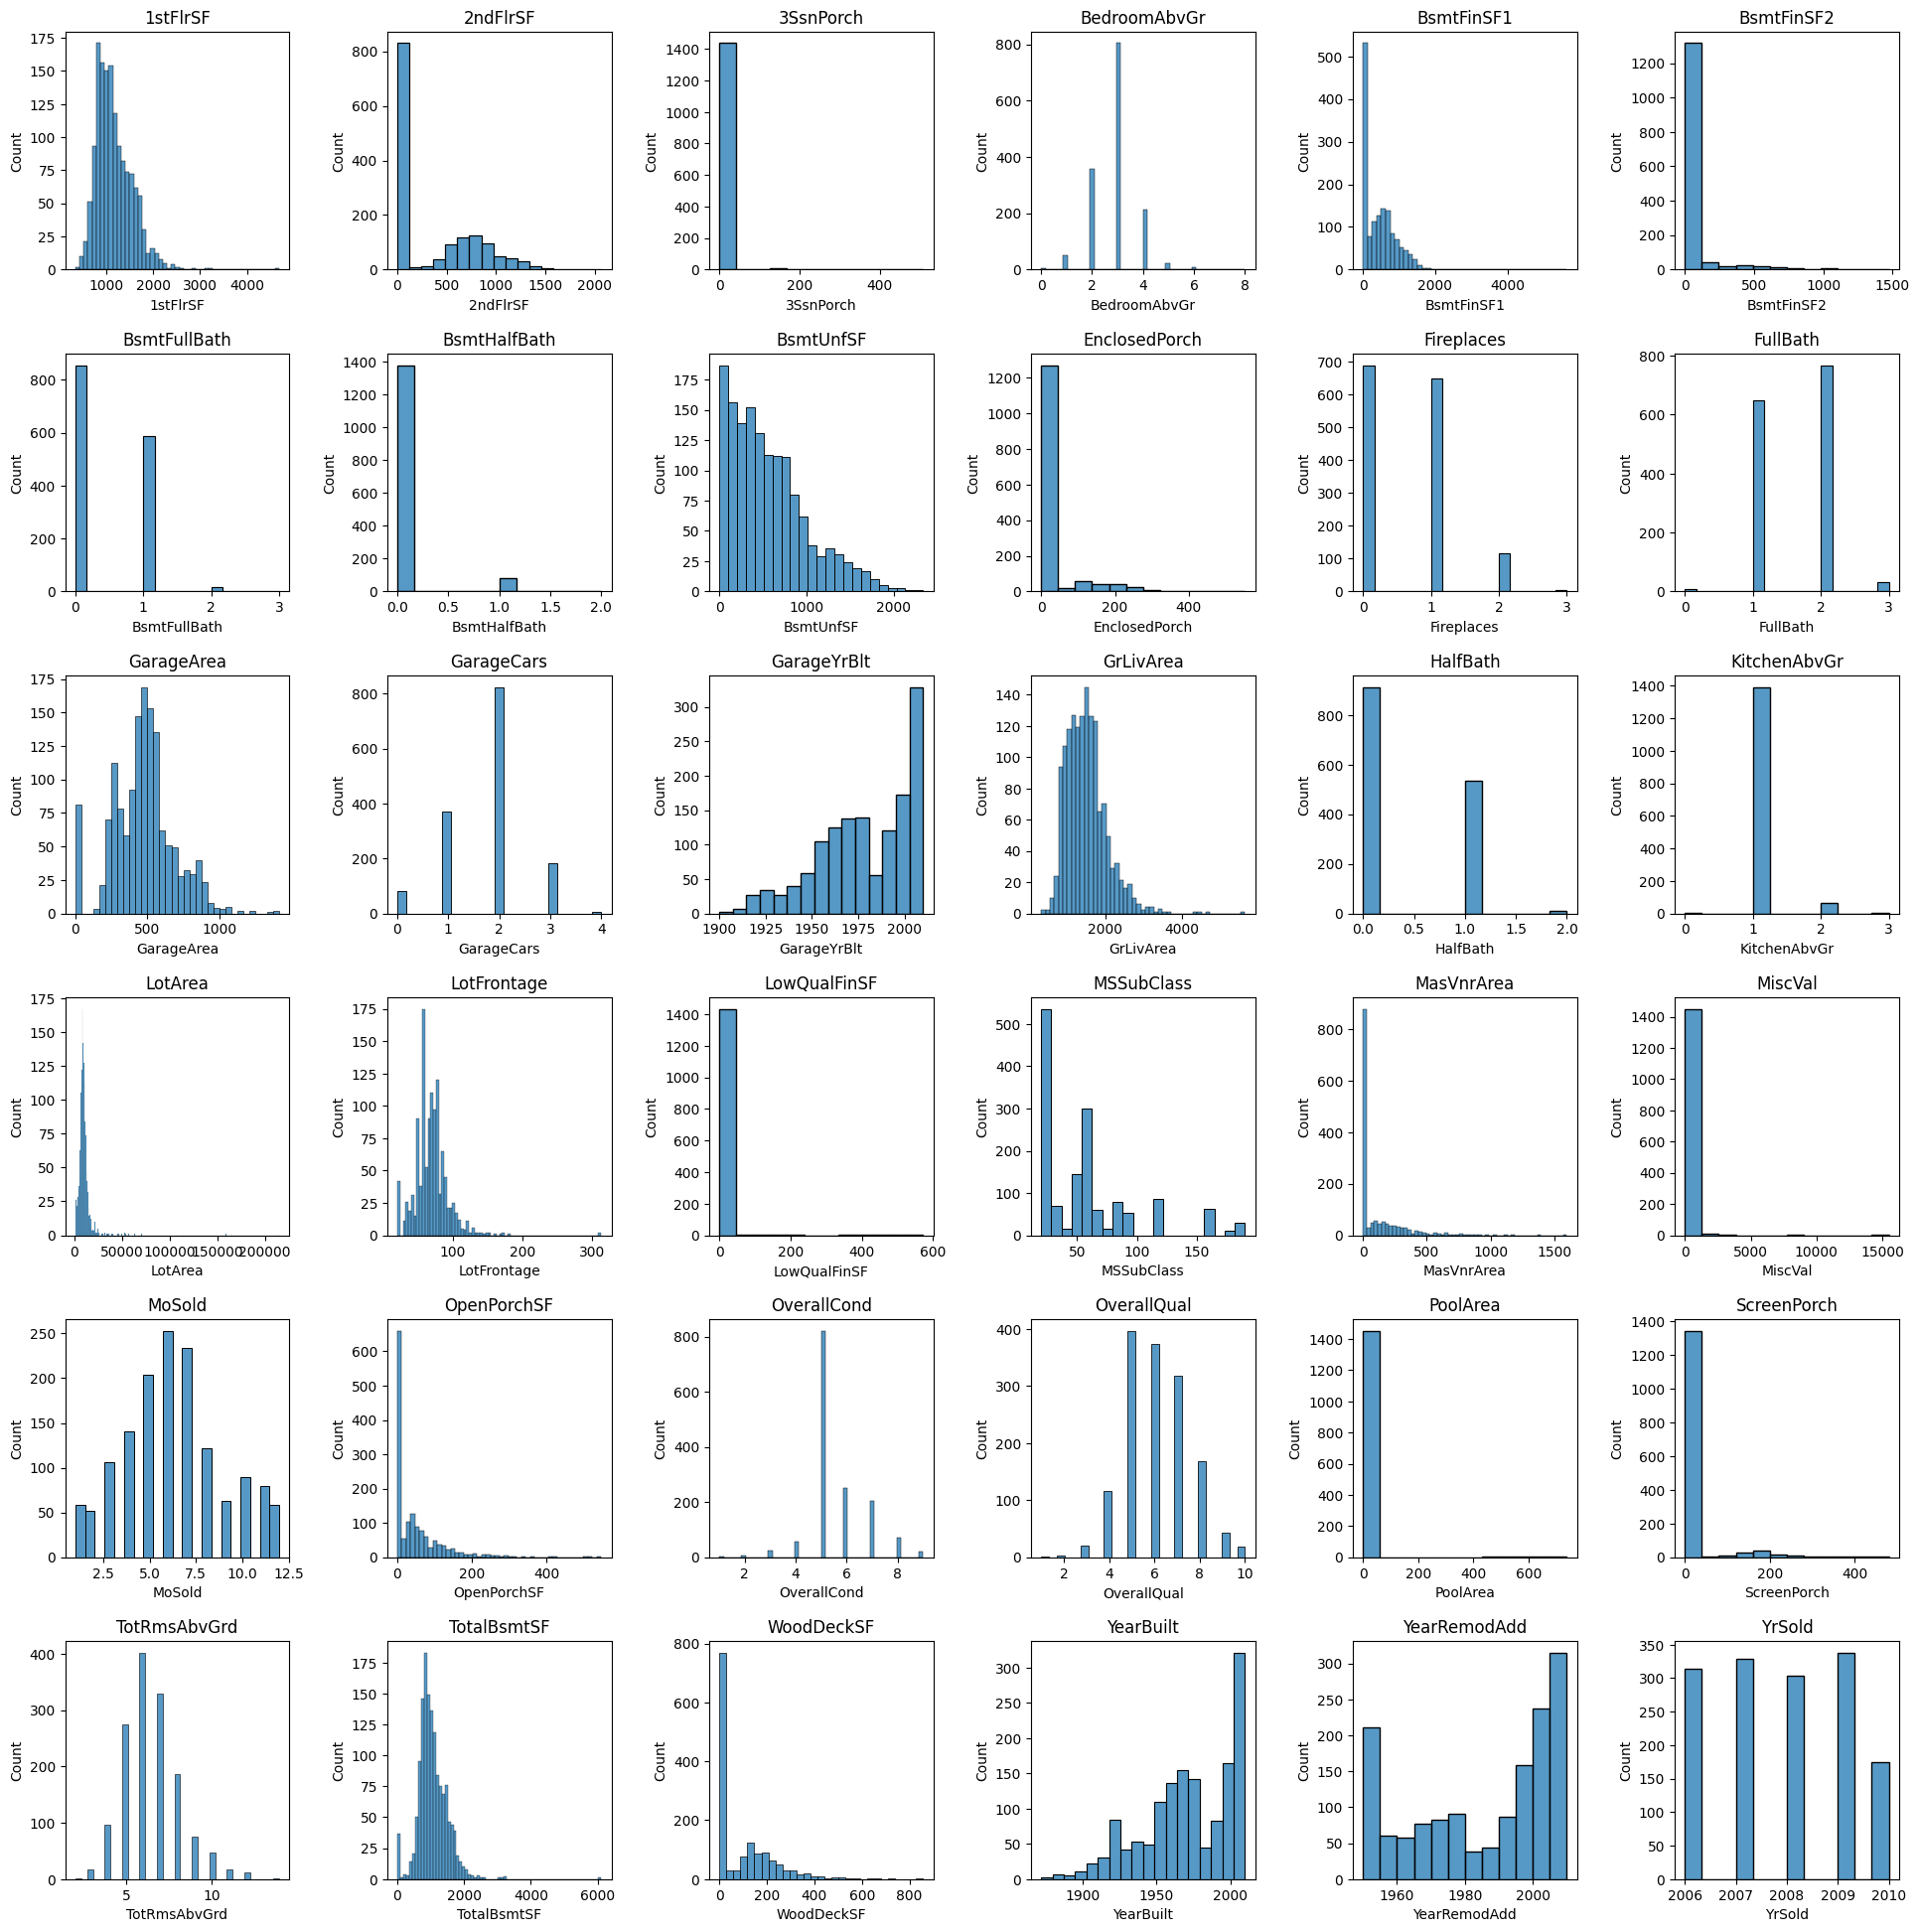

In [9]:
rows = 6  # Adjust as needed
cols = 6  # Adjust as needed
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout(pad=4.0)

# Iterate over the features and create a histogram for each
for i, feature in enumerate(num_features):
    row = i // cols
    col = i % cols
    sns.histplot(train[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

# If the number of features is not a multiple of rows*cols, hide the extra subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

Okay great now we can visually identify which variables make sense as categorical data from these distributions.

In [10]:
wrong_features = [
    "MSSubClass",
    "OverallQual", 
    "OverallCond", 
    "BsmtFullBath", 
    "BsmtHalfBath", 
    "FullBath", 
    "HalfBath", 
    "BedroomAbvGr", 
    "KitchenAbvGr", 
    "TotRmsAbvGrd", 
    "Fireplaces", 
    "GarageCars", 
    "MoSold", 
    "YrSold", 
]

# move features to correct place
for feature in wrong_features:
    num_features.remove(feature)
    cat_features.append(feature)

## Outlier Detection

We should drop outliers from our training data so our feature engineering and training results are not skewed by these outliers.

We can use isolation forrest, which is good for high dimensional data, can handle cat/num features, and is robust to missing data (we can impute missing values which will be treated as normal values).

In [11]:
# Create a pipeline for preprocessing
# For numerical features: impute missing values and standardize
# For categorical features: impute missing values and apply one-hot encoding
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            # missing values become median, these are considered to be normal during outlier detection
            ('imputer', SimpleImputer(strategy='median')),
        ]), num_features),
        ('cat', Pipeline([
            # missing values become most frequent, these are considered to be normal during outlier detection
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ])

# Drop the 'Id' and 'SalePrice' columns
train_mod = train.drop(columns=['Id', 'SalePrice'])

# Apply preprocessing
train_preprocessed = preprocessor.fit_transform(train_mod)

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)

# Fit and predict outliers (-1 for outliers, 1 for inliers)
outliers = iso_forest.fit_predict(train_preprocessed)

# Convert outliers to a boolean mask (True for rows to keep)
mask = outliers == 1

# Filter the original DataFrame to remove outliers
train_filtered = train[mask]

train_filtered

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706,0,...,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978,0,...,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486,0,...,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216,0,...,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655,0,...,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,NaN,3,1Fam,TA,No,0,0,...,WD,0,Pave,7,953,AllPub,0,1999,2000,2007
1456,2073,0,0,NaN,3,1Fam,TA,No,790,163,...,WD,0,Pave,7,1542,AllPub,349,1978,1988,2010
1457,1188,1152,0,NaN,4,1Fam,Gd,No,275,0,...,WD,0,Pave,9,1152,AllPub,0,1941,2006,2010
1458,1078,0,0,NaN,2,1Fam,TA,Mn,49,1029,...,WD,0,Pave,5,1078,AllPub,366,1950,1996,2010


It looks like only 2 entries were removed. This might be low. Let's see if it looks like there are more outliers that we missed and we can try to set a better contamination value for isolation forest.

Let's see how many outliers it looks like there are on a PCA.

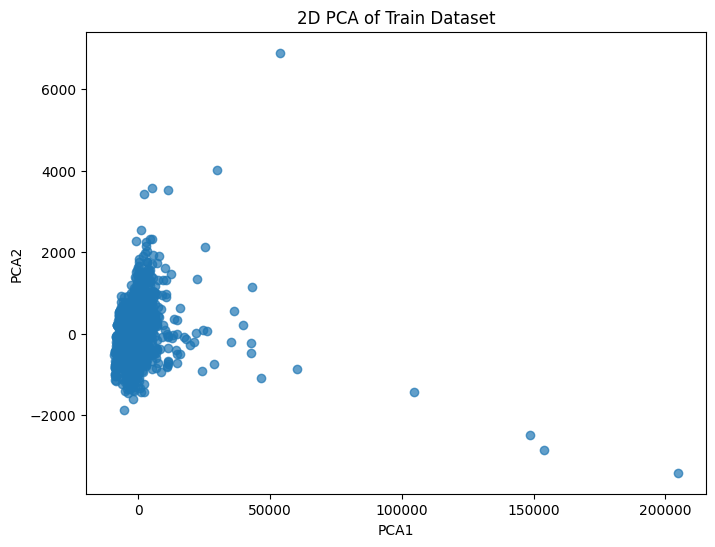

In [12]:
# Apply preprocessing
train_mod = train_filtered.drop(columns=['Id', 'SalePrice'])
train_preprocessed = preprocessor.fit_transform(train_mod)

# Convert the sparse matrix to a dense matrix
train_dense = train_preprocessed.toarray()

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_dense)

# Create a DataFrame for the 2D PCA components
train_pca_df = pd.DataFrame(train_pca, columns=['PCA1', 'PCA2'])

# Plot the 2D PCA components
plt.figure(figsize=(8, 6))
plt.scatter(train_pca_df['PCA1'], train_pca_df['PCA2'], alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('2D PCA of Train Dataset')
plt.show()


Okay, it looks like there are still some outliers that could be removed, I think 5 out of 1460. This is 0.00342. Let's see if this contamination value improves the outlier removal. 

In [13]:
# Drop the 'Id' and 'SalePrice' columns
train_mod = train.drop(columns=['Id', 'SalePrice'])

# Apply preprocessing
train_preprocessed = preprocessor.fit_transform(train_mod)

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.00342, random_state=42)

# Fit and predict outliers (-1 for outliers, 1 for inliers)
outliers = iso_forest.fit_predict(train_preprocessed)

# Convert outliers to a boolean mask (True for rows to keep)
mask = outliers == 1

# Filter the original DataFrame to remove outliers
train_filtered = train[mask]

train_filtered

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706,0,...,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978,0,...,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486,0,...,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216,0,...,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655,0,...,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,NaN,3,1Fam,TA,No,0,0,...,WD,0,Pave,7,953,AllPub,0,1999,2000,2007
1456,2073,0,0,NaN,3,1Fam,TA,No,790,163,...,WD,0,Pave,7,1542,AllPub,349,1978,1988,2010
1457,1188,1152,0,NaN,4,1Fam,Gd,No,275,0,...,WD,0,Pave,9,1152,AllPub,0,1941,2006,2010
1458,1078,0,0,NaN,2,1Fam,TA,Mn,49,1029,...,WD,0,Pave,5,1078,AllPub,366,1950,1996,2010


Let's check PCA again.

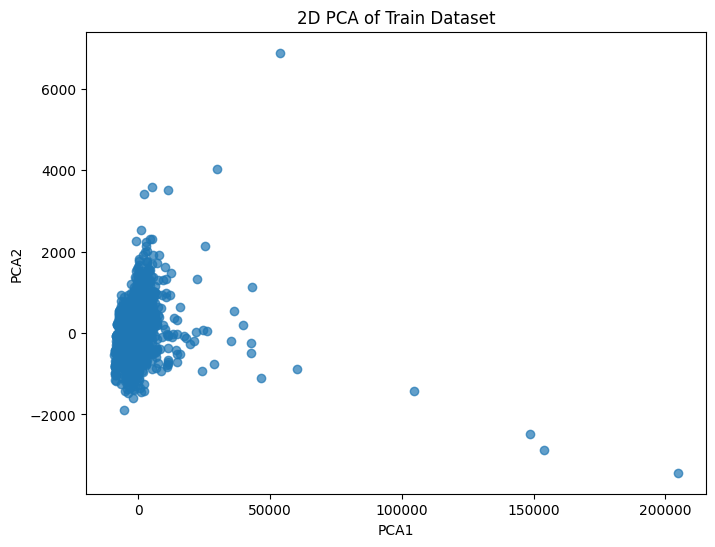

In [14]:
# Apply preprocessing
train_mod = train_filtered.drop(columns=['Id', 'SalePrice'])
train_preprocessed = preprocessor.fit_transform(train_mod)

# Convert the sparse matrix to a dense matrix
train_dense = train_preprocessed.toarray()

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_dense)

# Create a DataFrame for the 2D PCA components
train_pca_df = pd.DataFrame(train_pca, columns=['PCA1', 'PCA2'])

# Plot the 2D PCA components
plt.figure(figsize=(8, 6))
plt.scatter(train_pca_df['PCA1'], train_pca_df['PCA2'], alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('2D PCA of Train Dataset')
plt.show()


While we still have the outliers, I will continue as if they were removed.

In [15]:
train = train_filtered

## Join datasets

Combine train and test datasets so we can work with both at the same time.

In [16]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# sort columns alphabetically for easier finding later
dataset = dataset.reindex(sorted(dataset.columns), axis=1)

# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan) # np.nan must be better than native NaN

# Feature Analysis

## Nullity of Data

Lets look at the nullity matrix of the data so we can see what feature values we might have to engineer later.

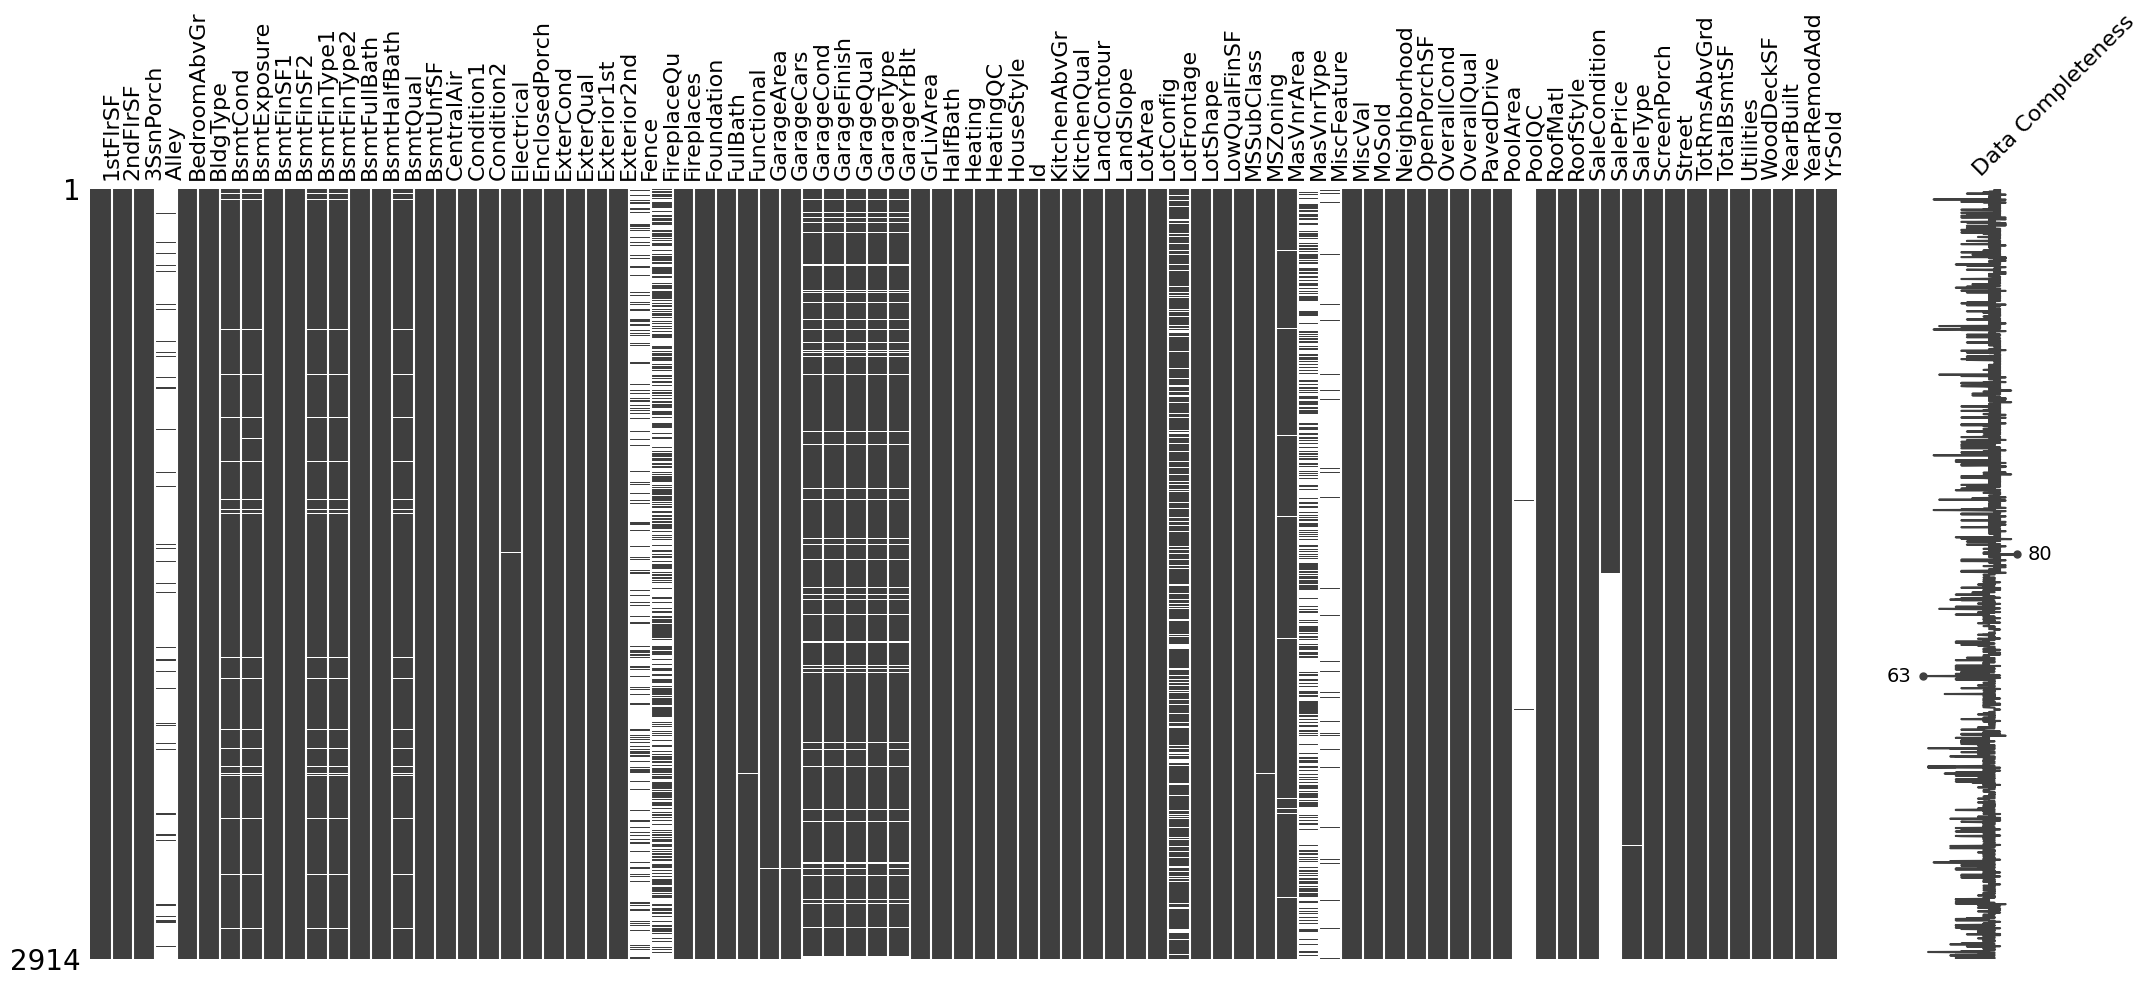

In [17]:
# Visualize the nullity matrix of the train DataFrame
msno.matrix(dataset, labels=True)
# Rotate feature names to be vertical
plt.xticks(rotation=90)
# Show the plot
plt.show()

It looks like some features are missing the majority of their values. We can determine how to impute these later.

## Target Variable

I think it will be interesting to see what kind of values we have represented for the SalePrice. This way we will know if prices in some house ranges are better accounted for than others.

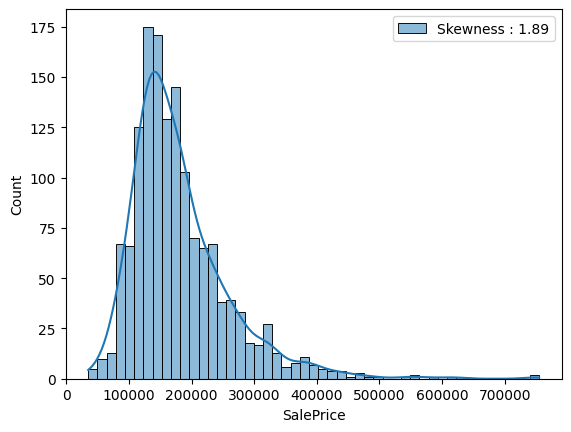

In [18]:
# See SalePrice representation in train data
g = sns.histplot(train["SalePrice"], kde=True, label="Skewness : %.2f"%(train["SalePrice"].skew()))
g = g.legend(loc="best")

Okay so we have a couple outlier homes in the higher price range. Hopefully this is the distribution of home prices across datasets, which should make it easier for our model to make predictions.

## Numerical Features

Let's start by making a heatmap of the numerical features.

[]

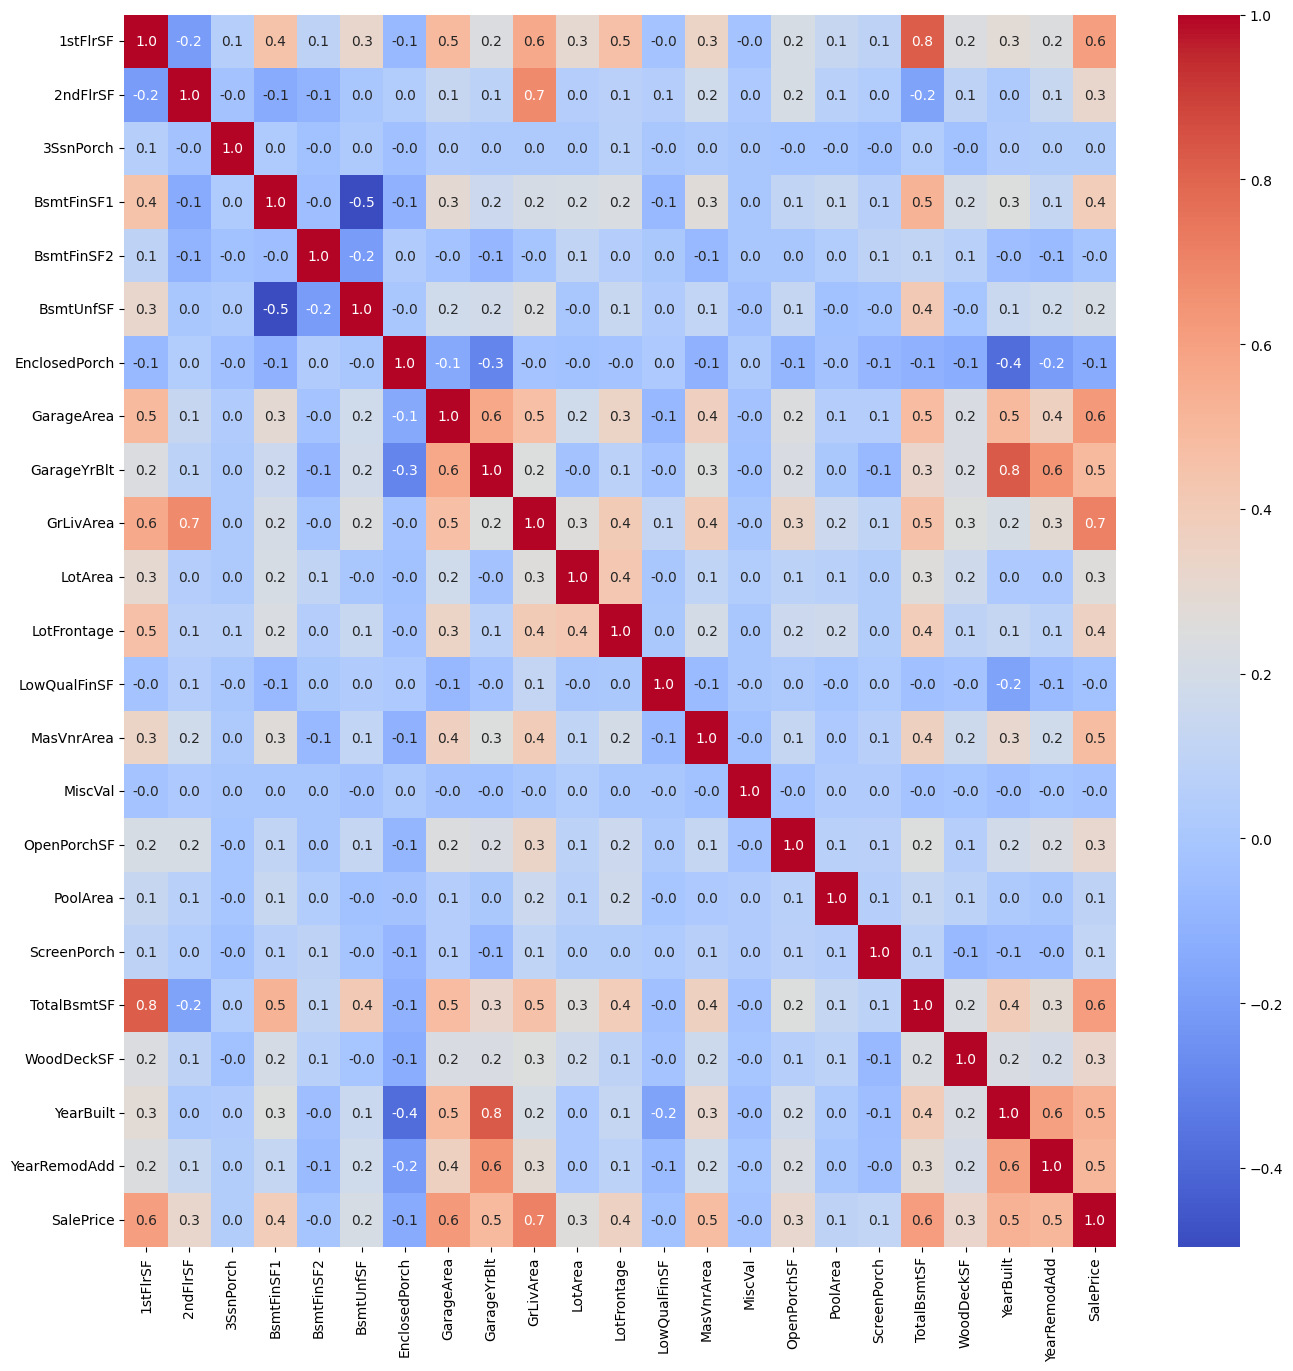

In [19]:
plt.figure(figsize = (16,16))
sns.heatmap(train[num_features + ["SalePrice"]].corr(), annot=True, fmt = ".1f", cmap = "coolwarm")
plt.plot()

Okay so some features have a very clear correlation with sale price. For example, GrLivArea has a high correlation with SalePrice. We should make sure to keep these features in our final model. 

We dont know if the other features are not useful yet though. The subpopulations might have correlations. Let's try to see if this is the case.

First we should determine which distributions are skewed and determine if we need to correct them.

## Check for skewed data

In [20]:
len(num_features)

22

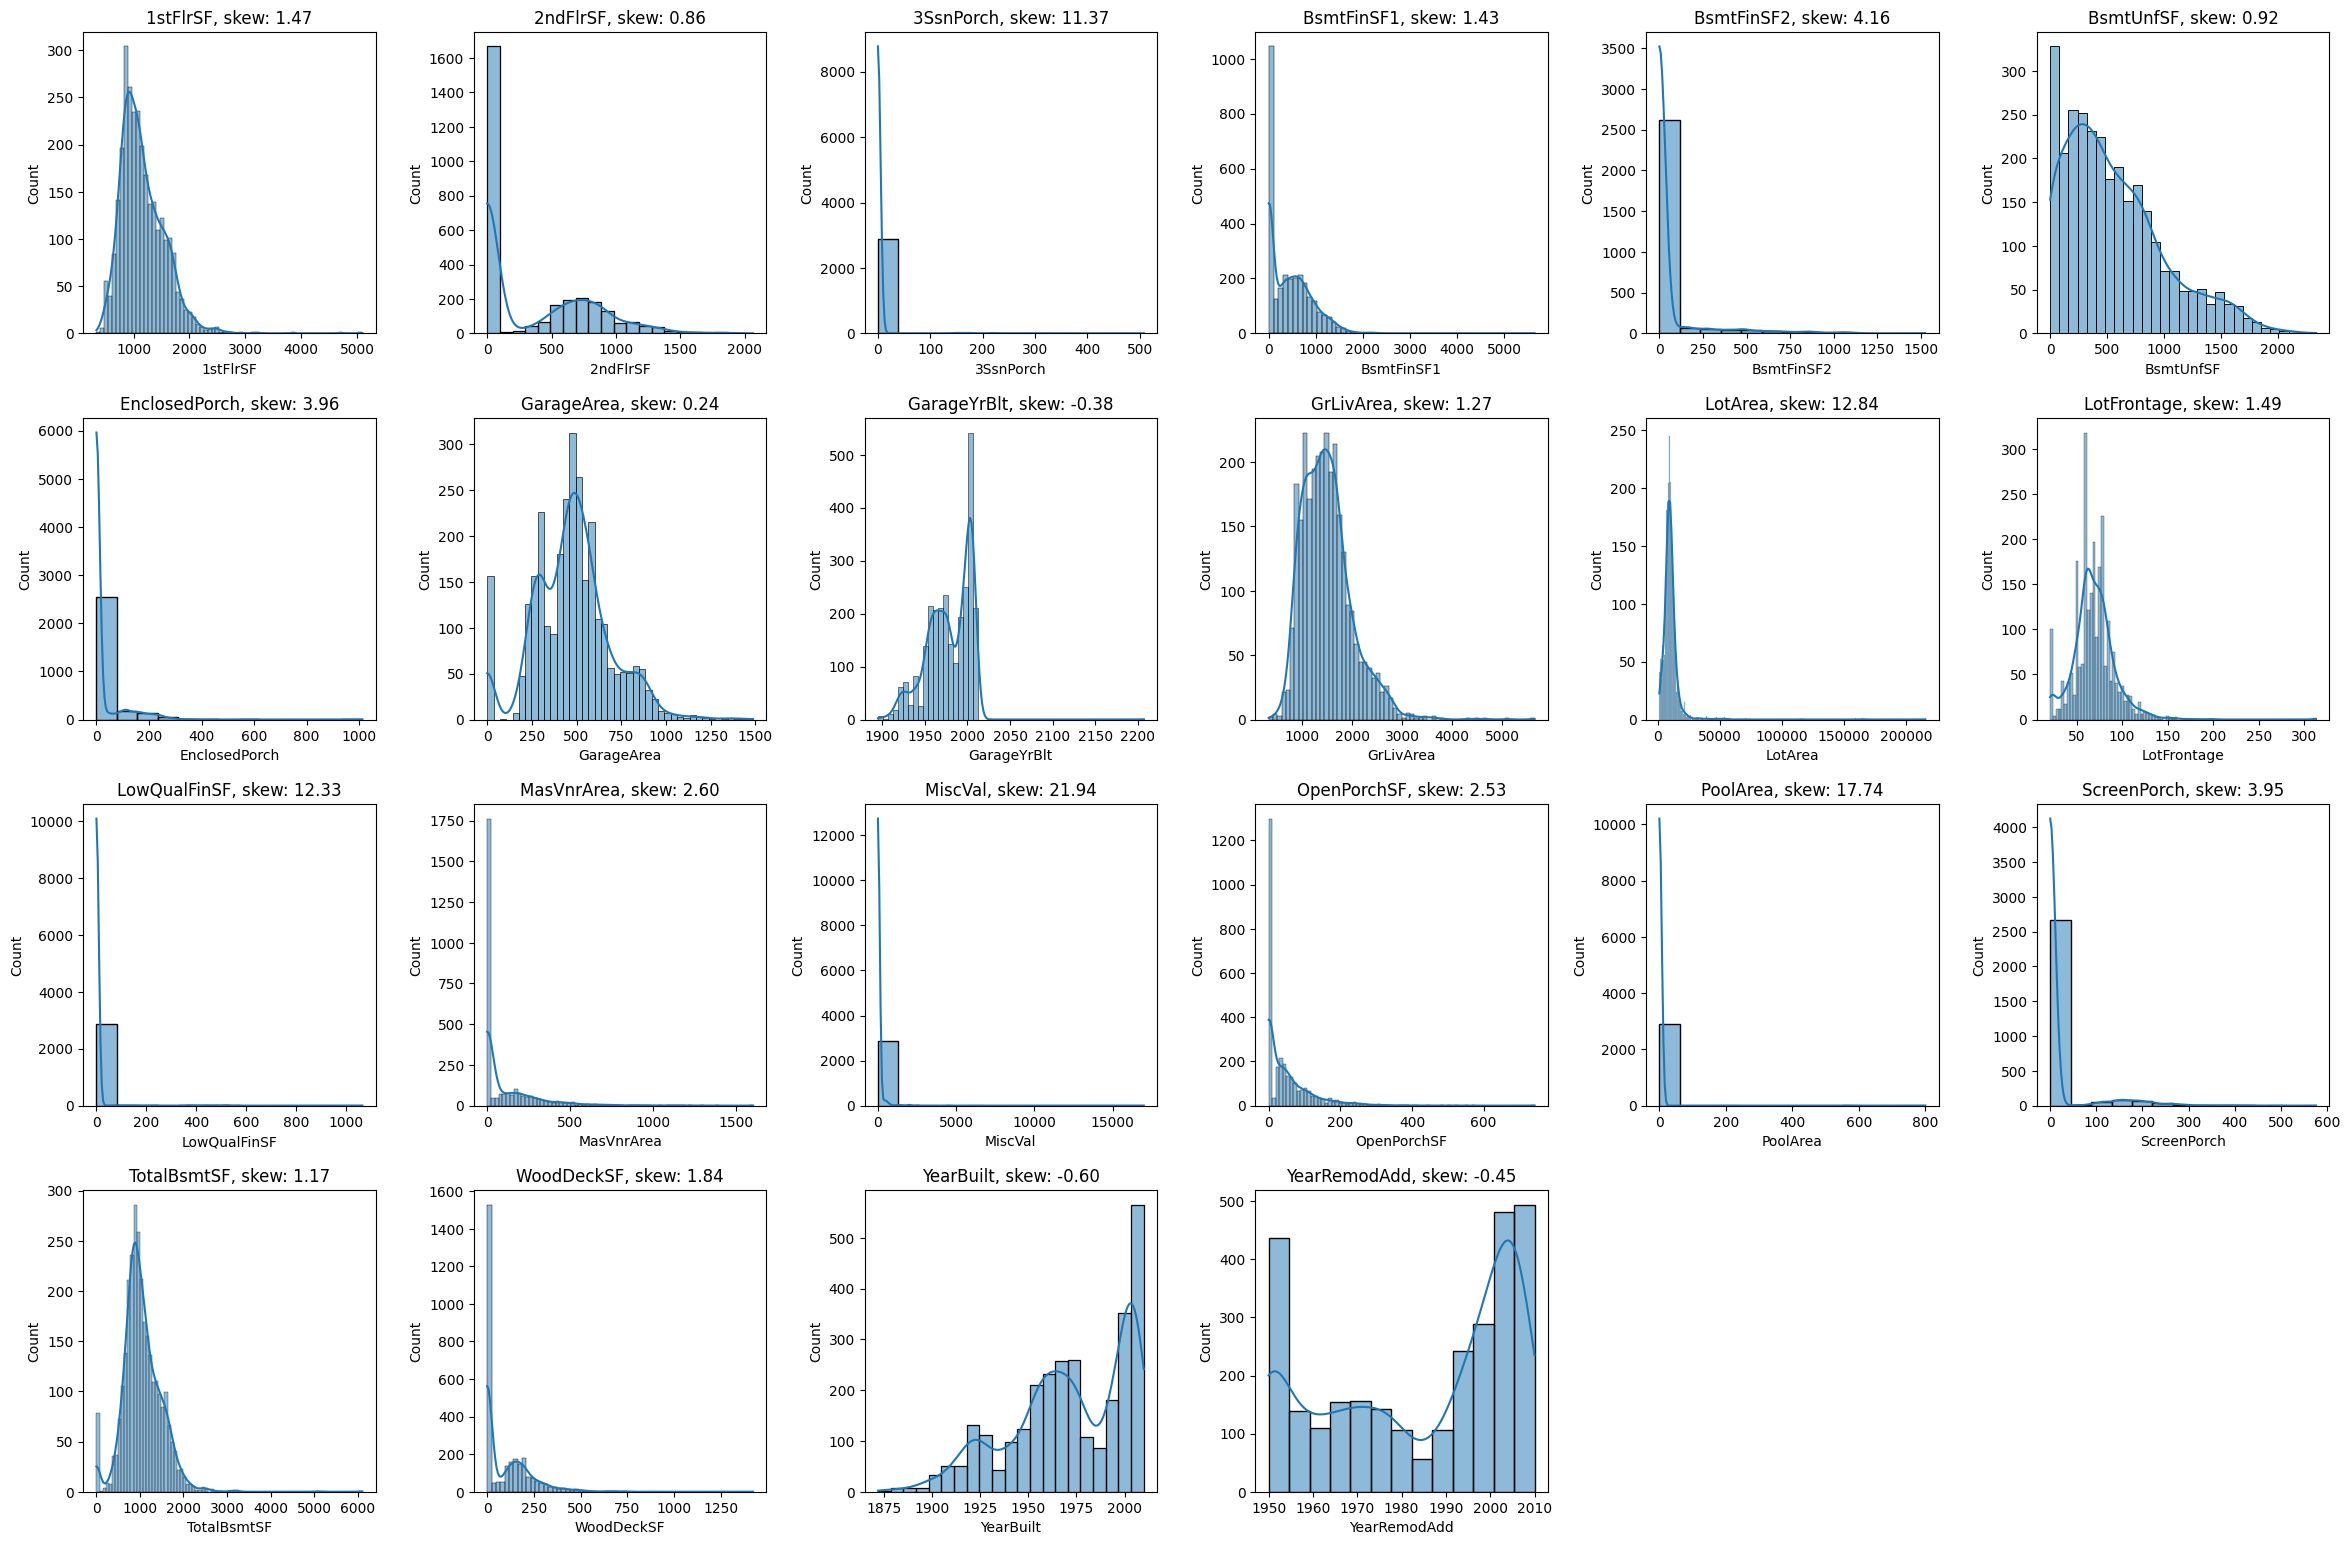

In [21]:
rows = 4  # Adjust as needed
cols = 6  # Adjust as needed
fig, axes = plt.subplots(rows, cols, figsize=(24, 16))
fig.tight_layout(pad=4.0)

# Iterate over the features and create a histogram for each
for i, feature in enumerate(num_features):
    row = i // cols
    col = i % cols
    sns.histplot(dataset[feature], ax=axes[row, col], kde=True)
    skewness = dataset[feature].skew()
    axes[row, col].set_title(f"{feature}, skew: {skewness:.2f}")

# If the number of features is not a multiple of rows*cols, hide the extra subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

Skewness values within -1/-0.5 and 0.5/1 indicate slight skewing. Clearly, we have significant skewage for many of these features. We will have to determine the best way to correct this skewing so the model does not have higher coefficient values related to these features, we can use more statistical techniques, etc.

## Categorical Features

Let's start by making a barplot of sale price averages for different categories of these features. As it turns out, Seaborns catplot is very helpful for this!

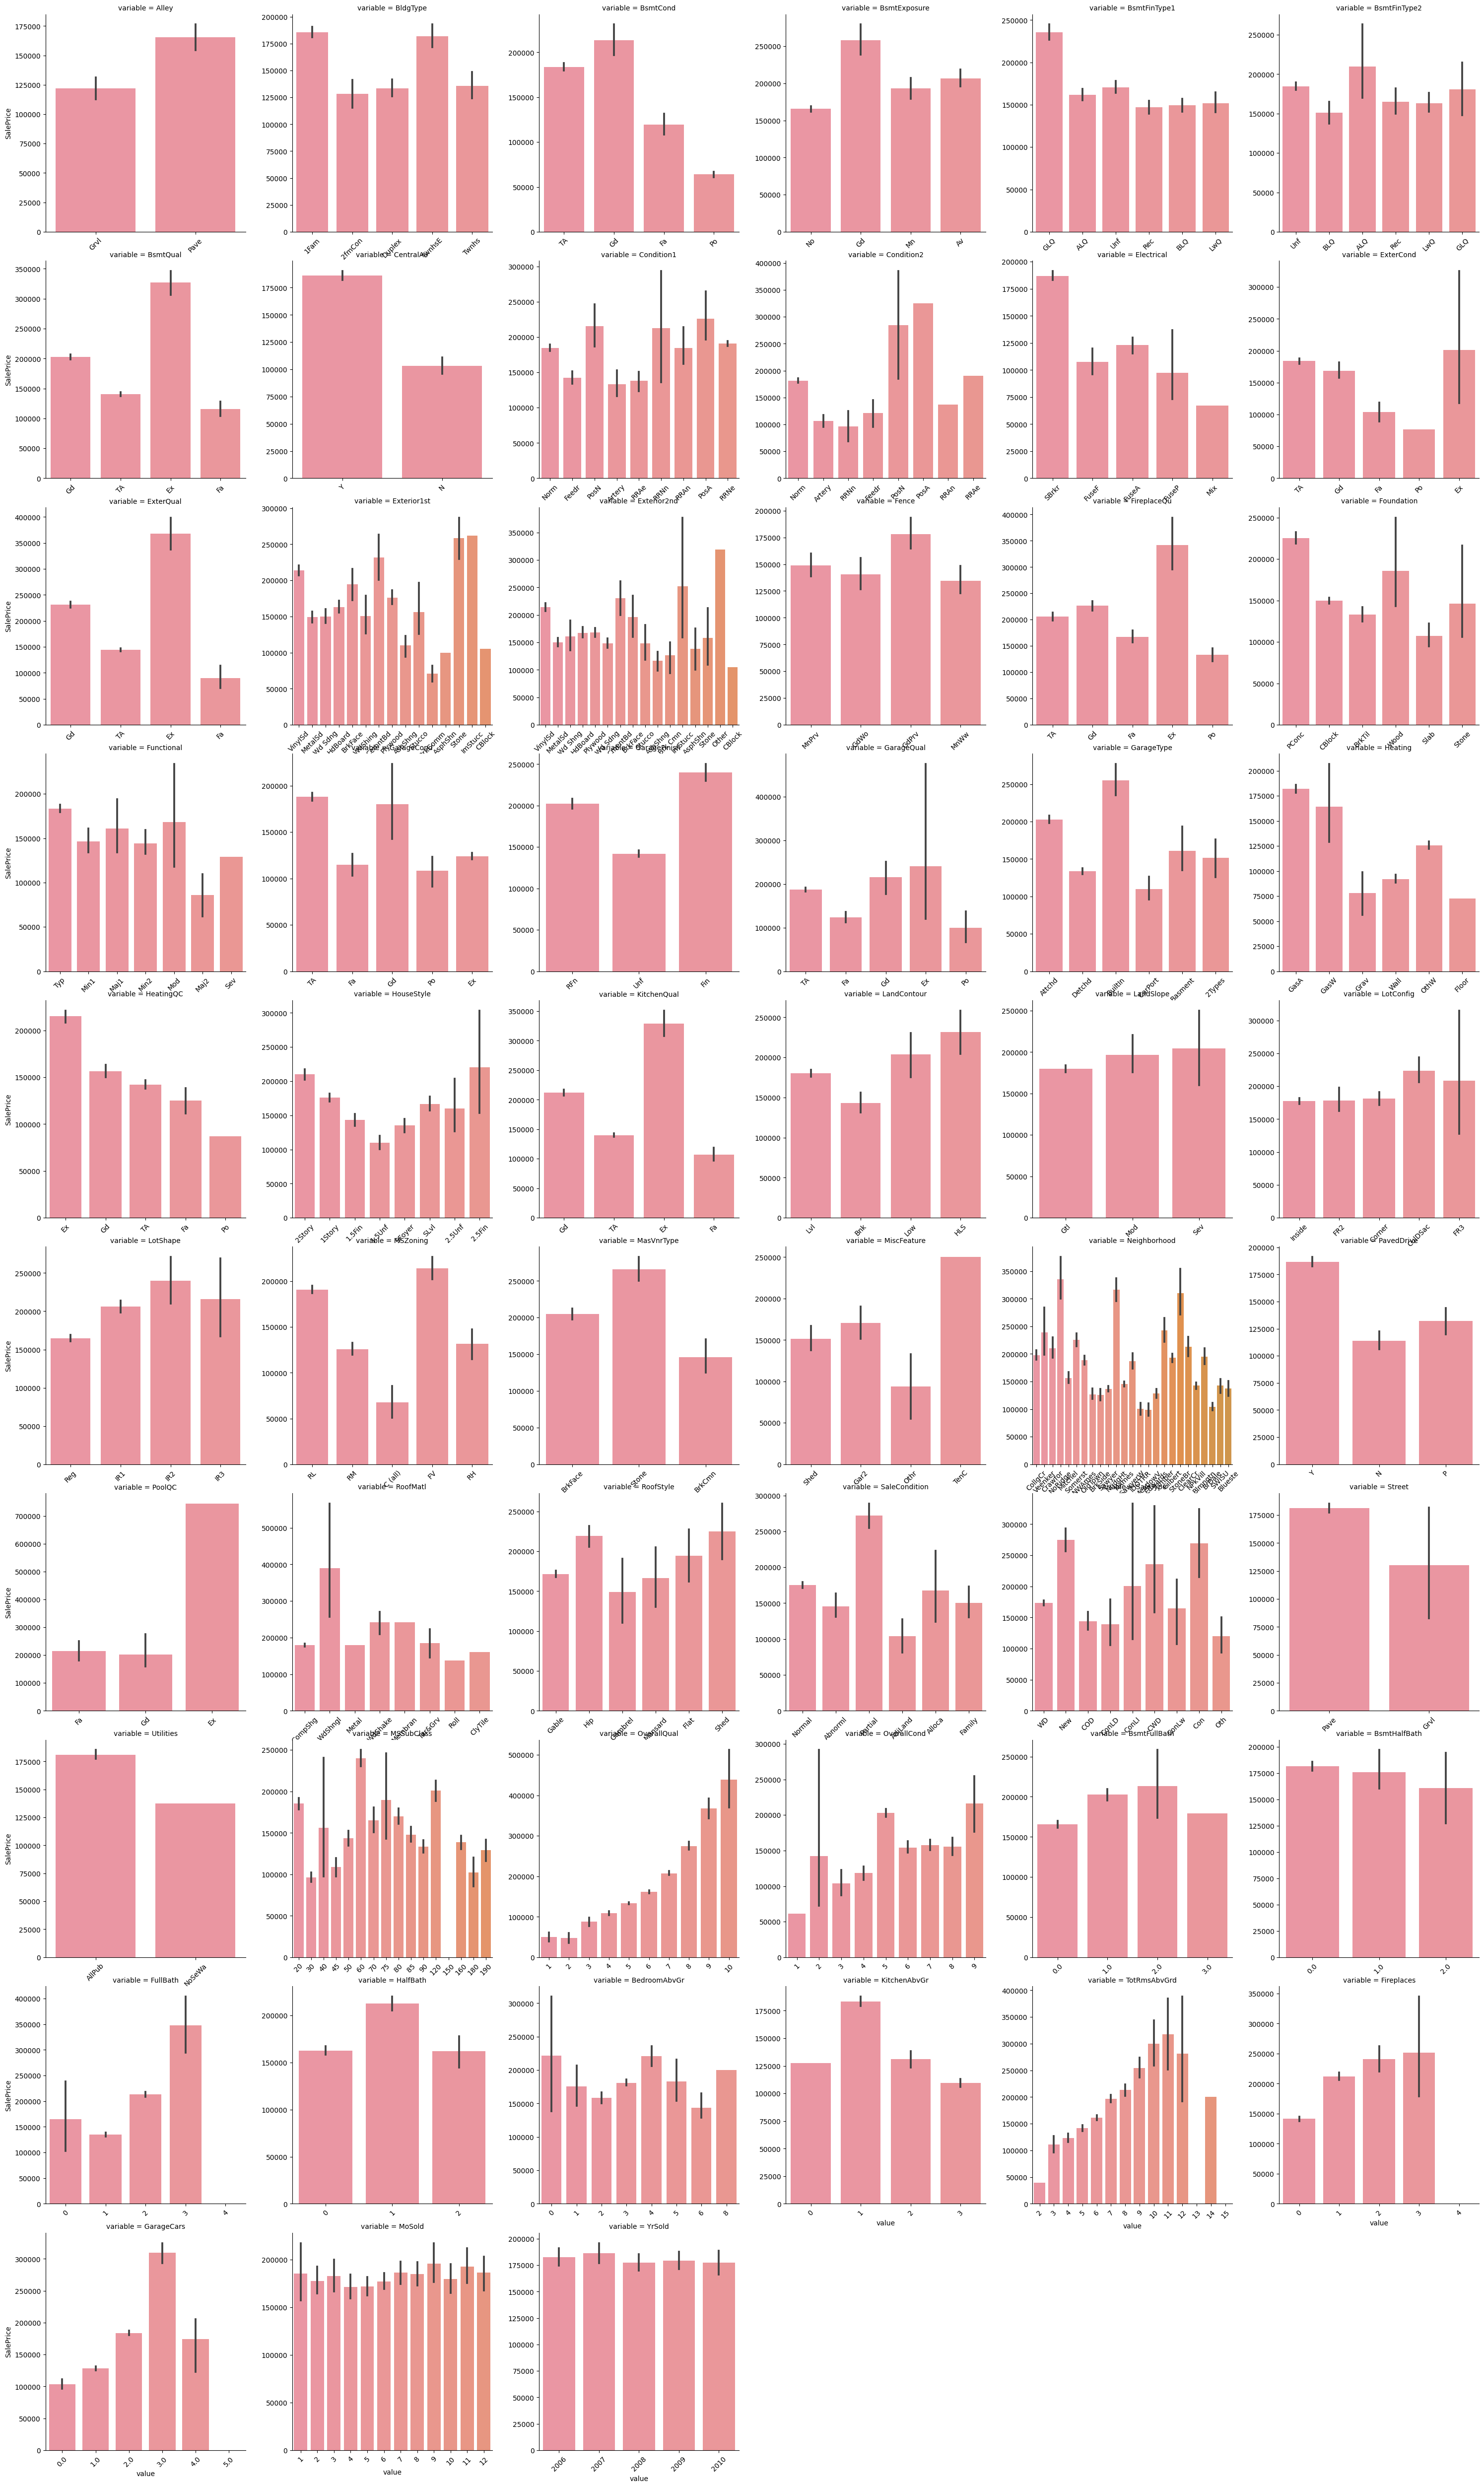

In [22]:
# Convert the 'cat_features' list into a long-format DataFrame
long_format = dataset.melt(id_vars='SalePrice', value_vars=cat_features)

# Create the catplot
g = sns.catplot(
    data=long_format, 
    x='value', 
    y='SalePrice', 
    col='variable', 
    kind='bar', 
    col_wrap=6,
    sharex=False, 
    sharey=False
)

# Rotate x labels for better readability
g.set_xticklabels(rotation=45)

plt.show()

It looks like most of these features have some relation to sale price. We can refer to this plot later when we decide if we want to impute missing column values or drop columns.

# Feature Engineering

Given the number of features in this dataset, I will let the model decide which features to use (regularization).

But, I want to give it the best chance of using these features.

## Numerical Feature Skew Correction

First, let's see how we can correct the skew we noticed in many of the numerical features earlier. Log transforms are usually used for right-skewed data. How does this transform perform here?

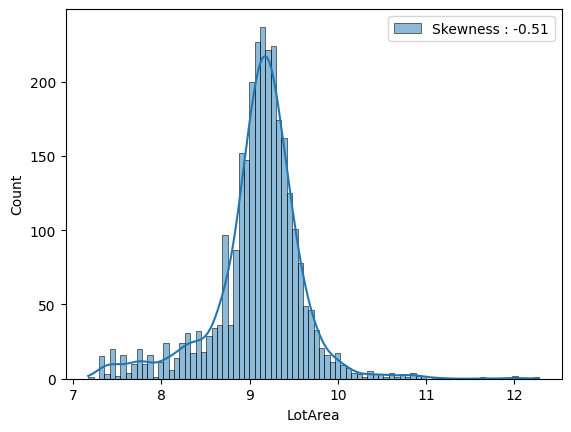

In [23]:
# Apply log to LotArea to reduce skewness distribution
log_feature = dataset["LotArea"].map(lambda i: np.log(i+1))

# Explore new LotArea distribution 
g = sns.histplot(log_feature, kde=True, label="Skewness : %.2f"%(log_feature.skew()))
g = g.legend(loc="best")

Alright, it looks like the skew in features like lot area can be fixed with a log transform. Let's see how it works for the features that have a significant number of 0s.

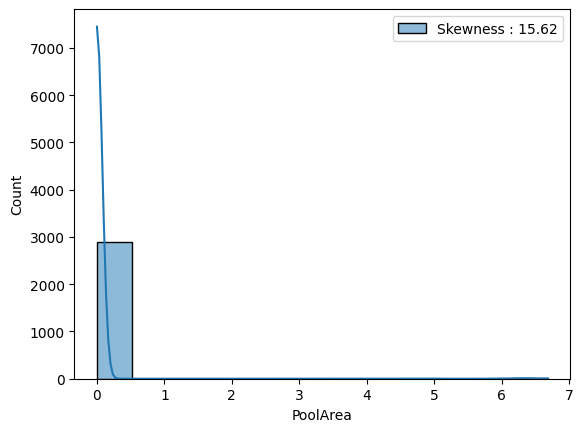

In [24]:
# Apply log to PoolArea to reduce skewness distribution
log_feature = dataset["PoolArea"].map(lambda i: np.log(i+1))

# Explore new PoolArea distribution 
g = sns.histplot(log_feature, kde=True, label="Skewness : %.2f"%(log_feature.skew()))
g = g.legend(loc="best")

Okay, so log is not so good at dealing with a large number of 0s. Let's do some research to find out what works better...

[This article](https://medium.com/@kangeugine/box-cox-transformation-ba01df7da884#:~:text=When%20you%20are%20dealing%20with%20real%2Dworld%20data%2C%20you%20are,validity%20of%20measures%20of%20association.) Discusses how box-cox can automatically learn the best way to turn skewed data into a more normal distribution. One caveat is that we must have all positive feature values. Even the nans must be removed :/

Let's see how it works for one of the worst skewed features.

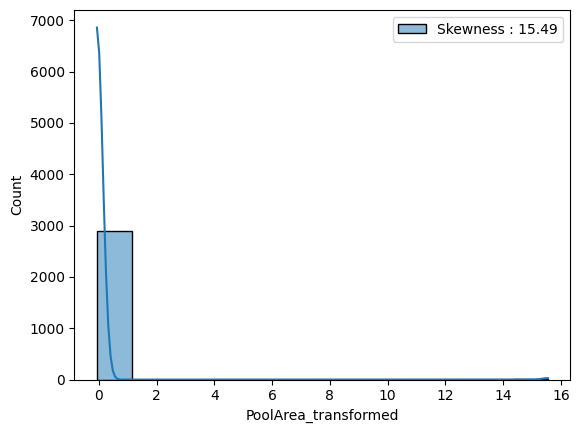

In [25]:
# Initialize the PowerTransformer
pt = PowerTransformer(method='box-cox')

# Reshape the data (necessary for a single feature)
PoolArea = dataset["PoolArea"].map(lambda i: i+1)
PoolArea = PoolArea.values
PoolArea = PoolArea[~np.isnan(PoolArea)]
PoolArea = PoolArea.reshape(-1, 1)


# Apply the power transformation
PoolArea_transformed = pt.fit_transform(PoolArea)

# Convert the transformed data back to a DataFrame for easier plotting
PoolArea_transformed_df = pd.DataFrame(PoolArea_transformed, columns=["PoolArea_transformed"])

# Explore new distribution 
g = sns.histplot(PoolArea_transformed_df["PoolArea_transformed"], kde=True, label="Skewness : %.2f"%(PoolArea_transformed_df["PoolArea_transformed"].skew()))
g = g.legend(loc="best")
plt.show()

Okay given the caveats and complexity of using Box-Cox and the fact that it doesn't seem much better than log transform, we can just apply log transform to the numerical features with a significant skew (|skew|>1).

It is important to remember that log transform only works for right skewed data (skew>0). Luckily, it looks like the features with significant skew have only right skew. We would have to consider other transform techniques for signficant left skew (ex square).

In [26]:
for num_feature in num_features:
    # if the feature doesn't have signficant positive skew we can skip
    skew = dataset[num_feature].skew()
    if skew < 1.5:
        continue
    
    # Apply log transform to feature to reduce skewness distribution
    dataset[num_feature] = dataset[num_feature].map(lambda i: np.log(i+1))

Now let's see what the new distributions look like.

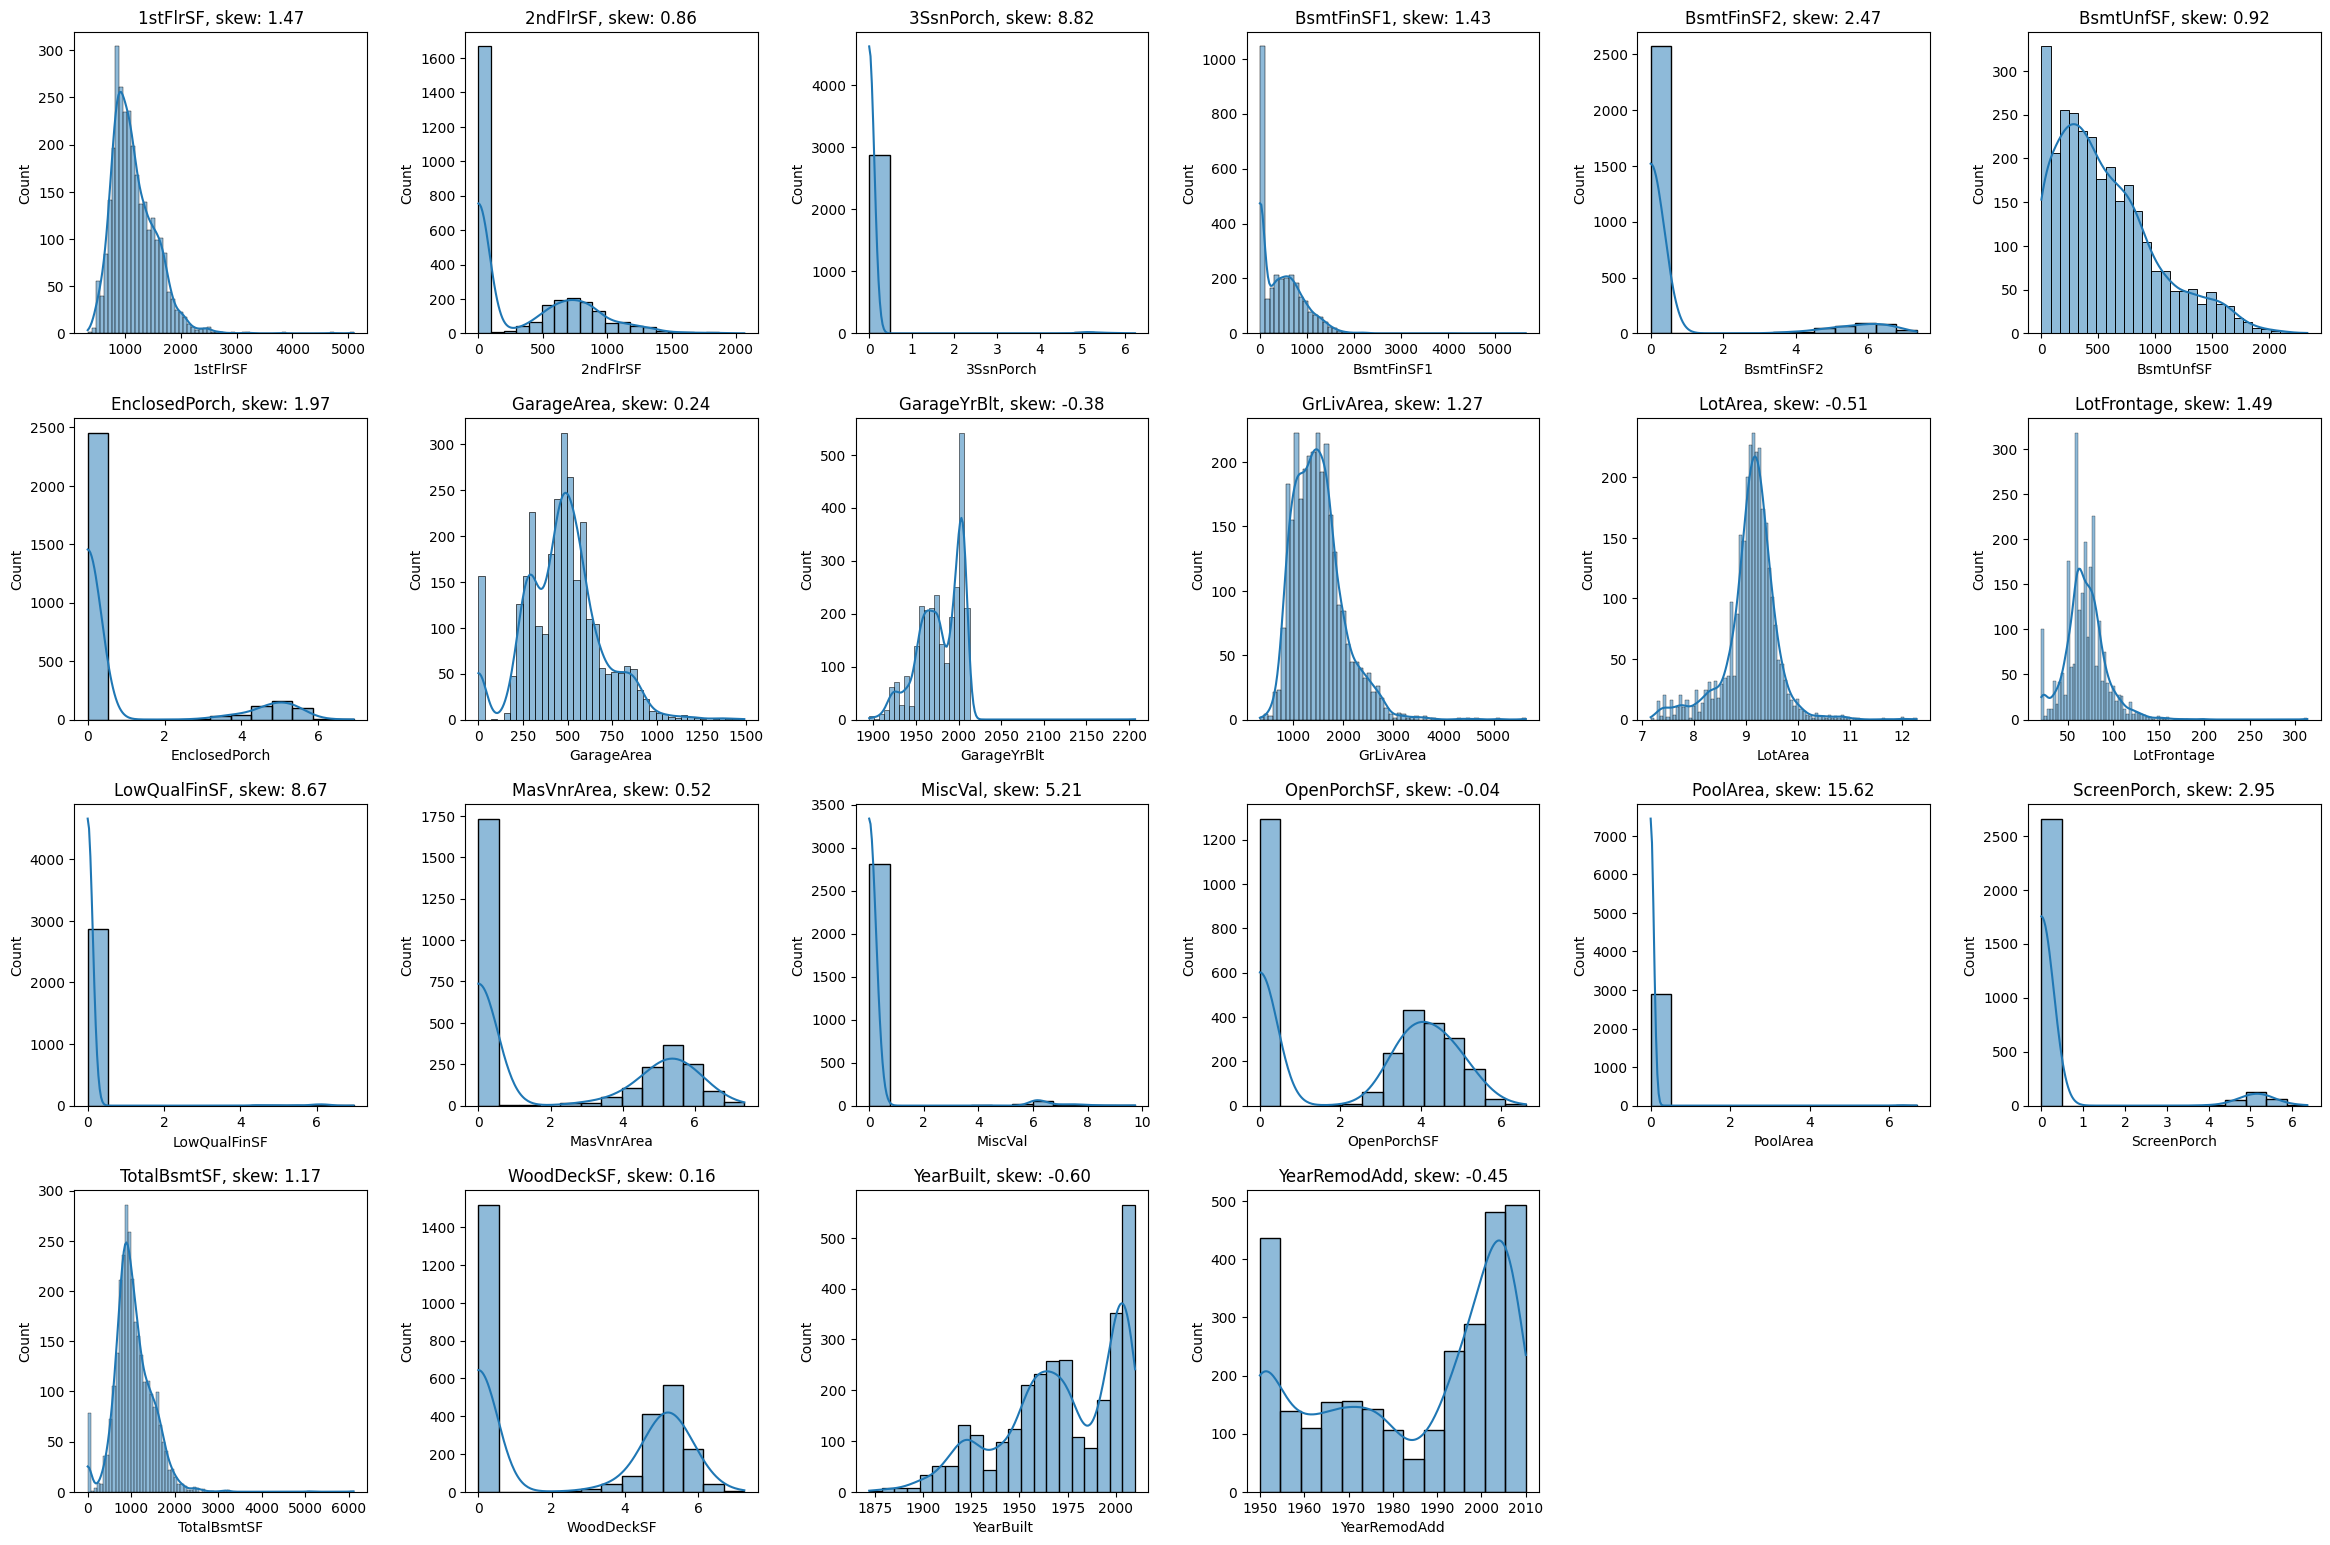

In [27]:
rows = 4  # Adjust as needed
cols = 6  # Adjust as needed
fig, axes = plt.subplots(rows, cols, figsize=(24, 16))
fig.tight_layout(pad=4.0)

# Iterate over the features and create a histogram for each
for i, feature in enumerate(num_features):
    row = i // cols
    col = i % cols
    sns.histplot(dataset[feature], ax=axes[row, col], kde=True)
    skewness = dataset[feature].skew()
    axes[row, col].set_title(f"{feature}, skew: {skewness:.2f}")

# If the number of features is not a multiple of rows*cols, hide the extra subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

While we couldn't fix all of the signifcant skews, we can continue. 

I have read that for the features that have a significant number of 0s, it might be better to use this as more of a cateogrical feature (0_PoolArea, true or false). While I will not try to implement this here, it is definitely worth considering for similar problems in the future.

## Imputing Values

As we noted earlier, many features are missing values. Out of the columns that are missing values, lets see how bad it is for the entire dataset.

<Axes: >

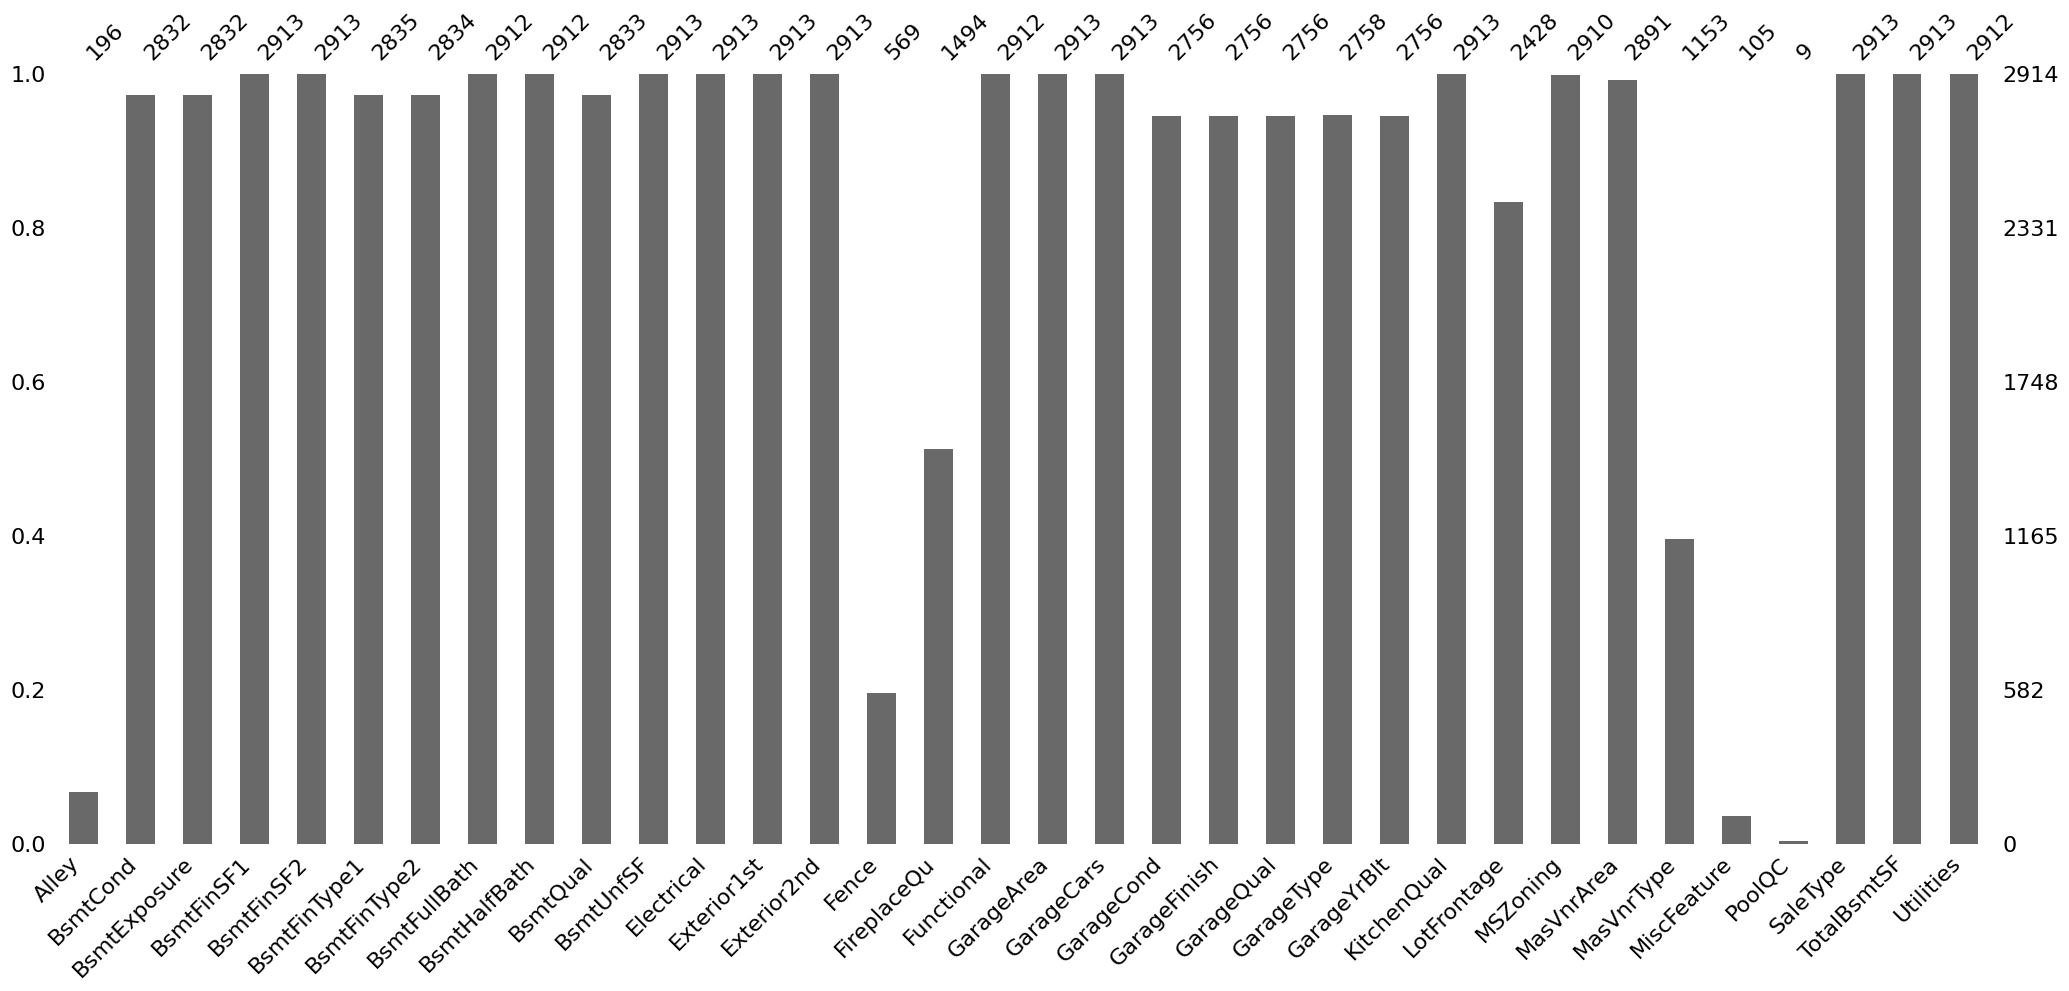

In [28]:
# Filter the DataFrame to include only columns with missing values
cols_with_missing_values = dataset.columns[dataset.isnull().any()].tolist()
filtered_dataset = dataset[cols_with_missing_values]

# drop SalePrice which is missing values for test dataset
filtered_dataset = filtered_dataset.drop(columns=["SalePrice"])

# Use missingno to plot the missing values
msno.bar(filtered_dataset)

Okay so that is a lot of columns with at least one value missing. It is clear that the extremely low representation of som features make them ripe for dropping. But every source I read says we should be very careful to not drop useful features.

The extremely low reprensentation features (=<0.5) include:

- Alley
- Fence
- FireplaceQu
- MasVnrType
- MiscFeature
- PoolQC

I think we can safely drop PoolQC and MiscFeature as I do not think these features will be super helpful with such low representation (based on bar plots). I imagine the rest could be useful even with null values to indicate something about the data. For example, houses without an alley likely get null and thus this column at least indicates if the house has an alley or not. 

I will try to use models that can make sense of null values. It might be worth trying to make categories like has_alley as well but this seems more complicated and I would rather let the model take care of it. For now, we can just replace nan values with "NULL" and let the models try to make sense of these missing values.

We can use simple imputation to fill in missing values for features that are missing <90% of their values. One issue with this imputation is that median on numerical features will go for/against the values that should be 0 (ex those that are missing a floor).

In [29]:
# drop low representation, likely unhelpful columns
dataset = dataset.drop(columns=["MiscFeature", "PoolQC"])

# remove these columns from our lists that we will keep using
cat_features.remove("MiscFeature")
cat_features.remove("PoolQC")

cols_with_missing_values.remove("MiscFeature")
cols_with_missing_values.remove("PoolQC")

In [30]:
# features that have low representation that we do not want to use simple imputation on
low_rep_features = ["Alley", "Fence", "FireplaceQu", "MasVnrType"]

# Replace NaN values with "NULL" in specific columns
for feature in low_rep_features:
    dataset[feature] = dataset[feature].fillna("NULL")

Now let's see if null has any correlation with SalePrice.

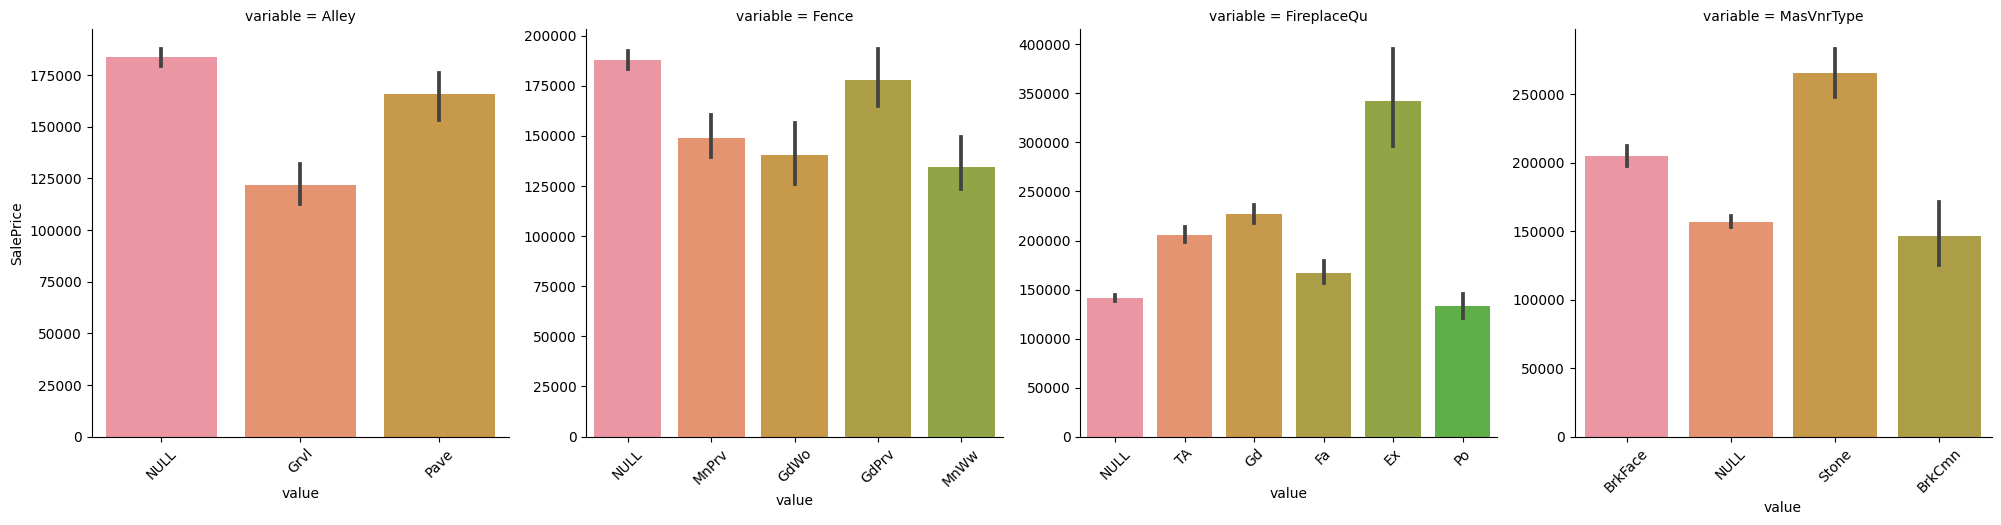

In [31]:
# Convert the 'cat_features' list into a long-format DataFrame
long_format = dataset.melt(id_vars='SalePrice', value_vars=low_rep_features)

# Create the catplot
g = sns.catplot(
    data=long_format, 
    x='value', 
    y='SalePrice', 
    col='variable', 
    kind='bar', 
    col_wrap=6,
    sharex=False, 
    sharey=False
)

# Rotate x labels for better readability
g.set_xticklabels(rotation=45)

plt.show()

Great. We get some information and we are able to keep these columns.

In [32]:
# impute missing values
imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
    ])

# Fit and transform the dataset using the imputer
imputed_data = imputer.fit_transform(dataset)
imputed_dataset = pd.DataFrame(imputed_data, columns=num_features+cat_features)

# Get imputed data into our dataframe
dataset[num_features+cat_features] = imputed_dataset[num_features+cat_features]

dataset

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856.0,854.0,0.0,NULL,3,1Fam,TA,No,706.0,0.0,...,WD,0.0,Pave,8,856.0,AllPub,0.0,2003.0,2003.0,2008
1,1262.0,0.0,0.0,NULL,3,1Fam,TA,Gd,978.0,0.0,...,WD,0.0,Pave,6,1262.0,AllPub,5.700444,1976.0,1976.0,2007
2,920.0,866.0,0.0,NULL,3,1Fam,TA,Mn,486.0,0.0,...,WD,0.0,Pave,6,920.0,AllPub,0.0,2001.0,2002.0,2008
3,961.0,756.0,0.0,NULL,3,1Fam,Gd,No,216.0,0.0,...,WD,0.0,Pave,7,756.0,AllPub,0.0,1915.0,1970.0,2006
4,1145.0,1053.0,0.0,NULL,4,1Fam,TA,Av,655.0,0.0,...,WD,0.0,Pave,9,1145.0,AllPub,5.26269,2000.0,2000.0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,546.0,546.0,0.0,NULL,3,Twnhs,TA,No,0.0,0.0,...,WD,0.0,Pave,5,546.0,AllPub,0.0,1970.0,1970.0,2006
2910,546.0,546.0,0.0,NULL,3,TwnhsE,TA,No,252.0,0.0,...,WD,0.0,Pave,6,546.0,AllPub,0.0,1970.0,1970.0,2006
2911,1224.0,0.0,0.0,NULL,4,1Fam,TA,No,1224.0,0.0,...,WD,0.0,Pave,7,1224.0,AllPub,6.163315,1960.0,1996.0,2006
2912,970.0,0.0,0.0,NULL,3,1Fam,TA,Av,337.0,0.0,...,WD,0.0,Pave,6,912.0,AllPub,4.394449,1992.0,1992.0,2006


# Model Training


I will try using various models to predict SalePrice from the features.

First, we need to get categorical features as one hot encoded values. While we would want to use label encoding for something like OverallQuality, we can try just doing one hot encoding on all values for now. 

Note that I have not standardized the numerical features. I will try this later.

In [33]:
# convert all categorical features to strings (some are ints, objects)
dataset[cat_features] = dataset[cat_features].astype('category')

# one-hot encode categorical features
dataset = pd.get_dummies(dataset, columns=cat_features)

# convert all numerical features to floats (some are objects)
dataset[num_features] = dataset[num_features].astype('float')

dataset

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,GarageArea,GarageYrBlt,GrLivArea,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,856.0,854.0,0.0,706.0,0.0,150.0,0.000000,548.0,2003.0,1710.0,...,False,False,False,False,False,False,False,True,False,False
1,1262.0,0.0,0.0,978.0,0.0,284.0,0.000000,460.0,1976.0,1262.0,...,False,False,False,False,False,False,True,False,False,False
2,920.0,866.0,0.0,486.0,0.0,434.0,0.000000,608.0,2001.0,1786.0,...,False,True,False,False,False,False,False,True,False,False
3,961.0,756.0,0.0,216.0,0.0,540.0,5.609472,642.0,1998.0,1717.0,...,False,False,False,False,False,True,False,False,False,False
4,1145.0,1053.0,0.0,655.0,0.0,490.0,0.000000,836.0,2000.0,2198.0,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,546.0,546.0,0.0,0.0,0.0,546.0,0.000000,0.0,1979.0,1092.0,...,False,False,False,False,False,True,False,False,False,False
2910,546.0,546.0,0.0,252.0,0.0,294.0,0.000000,286.0,1970.0,1092.0,...,False,False,False,False,False,True,False,False,False,False
2911,1224.0,0.0,0.0,1224.0,0.0,0.0,0.000000,576.0,1960.0,1224.0,...,False,True,False,False,False,True,False,False,False,False
2912,970.0,0.0,0.0,337.0,0.0,575.0,0.000000,0.0,1979.0,970.0,...,False,False,False,False,False,True,False,False,False,False


In [34]:
train_data = dataset[dataset['SalePrice'].notnull()]

# Assuming 'train' is your training dataset
X = train_data.drop(["Id",'SalePrice'], axis=1)  # colums that are not features
y = train_data['SalePrice']  # Target variable

print(f"X has shape {X.shape}")
print(f"y has shape {y.shape}")

X has shape (1455, 374)
y has shape (1455,)


In [35]:
# create stratified folds for cross validation
kfold = StratifiedKFold(n_splits=10)

Training XGBRegressor ...
Training LinearRegression ...
Training Ridge ...
Training Lasso ...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e+11, tolerance: 8.151e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.322e+11, tolerance: 8.254e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+11, tolerance: 8.491e

Training ElasticNet ...
Training RandomForestRegressor ...
Training GradientBoostingRegressor ...
Training SVR ...
Training KNeighborsRegressor ...
Training AdaBoostRegressor ...


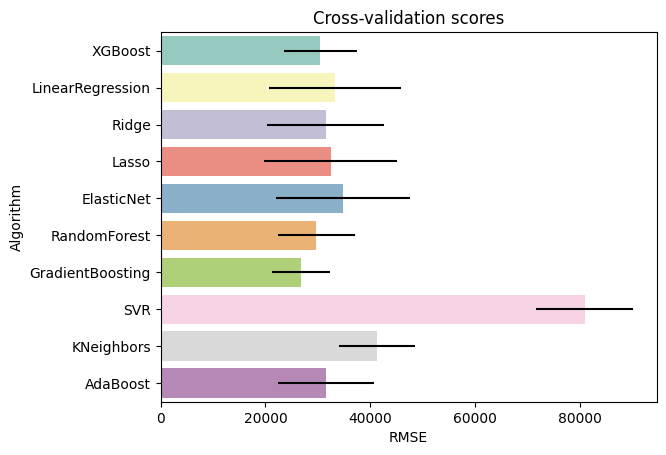

In [36]:
# Random state for sklearn operations
random_state = 2

# Define regressors to use
regressors = [
    XGBRegressor(random_state=random_state),
    LinearRegression(),
    Ridge(random_state=random_state),
    Lasso(random_state=random_state, max_iter=10000),
    ElasticNet(random_state=random_state, max_iter=10000),
    RandomForestRegressor(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state),
    SVR(),
    KNeighborsRegressor(),
    AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), random_state=random_state, learning_rate=0.1)
]

# Derive performance statistics for all models
cv_results = []
for regressor in regressors:
    print(f"Training {regressor.__class__.__name__} ...")
    result = cross_val_score(regressor, X, y, scoring="neg_mean_squared_error", cv=10, n_jobs=4)
    cv_results.append(result)

cv_means = []
cv_std = []
for cv_result in cv_results:
    # Calculate RMSE for each fold
    rmse_scores = np.sqrt(-cv_result)
    # add to results
    cv_means.append(rmse_scores.mean())
    cv_std.append(rmse_scores.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors": cv_std, "Algorithm":["XGBoost", "LinearRegression", "Ridge", "Lasso", "ElasticNet", "RandomForest", "GradientBoosting", "SVR", "KNeighbors", "AdaBoost"]})

g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h", xerr=cv_std)
g.set_xlabel("RMSE")
g.set_title("Cross-validation scores")

plt.show()

Alright, looks like the gradient boosting method is the best.

Now let's try standardizing our numerical features and see what effect this has on the model's performance.

In [37]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler only on the numerical features
dataset[num_features] = scaler.fit_transform(dataset[num_features])

Great, now let's see if the models perform differently.

In [38]:
train_data = dataset[dataset['SalePrice'].notnull()]

# Assuming 'train' is your training dataset
X = train_data.drop(["Id",'SalePrice'], axis=1)  # colums that are not features
y = train_data['SalePrice']  # Target variable

print(f"X has shape {X.shape}")
print(f"y has shape {y.shape}")

X has shape (1455, 374)
y has shape (1455,)


In [39]:
# create stratified folds for cross validation
kfold = StratifiedKFold(n_splits=10)

Training XGBRegressor ...
Training Ridge ...
Training Lasso ...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.825e+09, tolerance: 8.298e+08
  model = cd_fast.enet_coordinate_descent(


Training ElasticNet ...
Training RandomForestRegressor ...
Training GradientBoostingRegressor ...
Training SVR ...
Training KNeighborsRegressor ...
Training AdaBoostRegressor ...


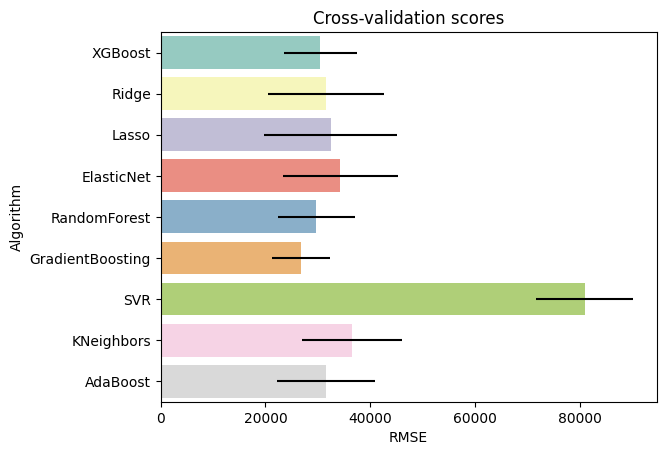

In [40]:
# Random state for sklearn operations
random_state = 2

# Define regressors to use
regressors = [
    XGBRegressor(random_state=random_state),
    # LinearRegression(),
    Ridge(random_state=random_state),
    Lasso(random_state=random_state, max_iter=10000),
    ElasticNet(random_state=random_state, max_iter=10000),
    RandomForestRegressor(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state),
    SVR(),
    KNeighborsRegressor(),
    AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state), random_state=random_state, learning_rate=0.1)
]

# Derive performance statistics for all models
cv_results = []
for regressor in regressors:
    print(f"Training {regressor.__class__.__name__} ...")
    result = cross_val_score(regressor, X, y, scoring="neg_mean_squared_error", cv=10, n_jobs=4)
    cv_results.append(result)

cv_means = []
cv_std = []
for cv_result in cv_results:
    # Calculate RMSE for each fold
    rmse_scores = np.sqrt(-cv_result)
    # add to results
    cv_means.append(rmse_scores.mean())
    cv_std.append(rmse_scores.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors": cv_std, "Algorithm":["XGBoost", "Ridge", "Lasso", "ElasticNet", "RandomForest", "GradientBoosting", "SVR", "KNeighbors", "AdaBoost"]})

g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h", xerr=cv_std)
g.set_xlabel("RMSE")
g.set_title("Cross-validation scores")

plt.show()

Alright, it looks like everything did about as well as with no scaling. GradientDescent is still the best.

Note that feature scaling makes the RMSE for LinearRegression so large that it does not show on this graph. A uesr explains in this [forum](https://datascience.stackexchange.com/questions/114889/feature-scaling-in-linear-regression) that unlike the algorithms that use gradient descent (and thus benefit from scaling), LinearRegression uses a normal equation and thus does not benefit from scaling.

## Overfitting

Before we the best model on all of our data, we should see much it overfits. 

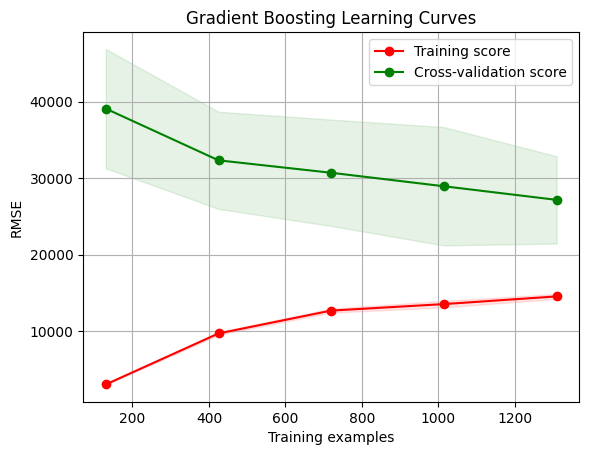

In [41]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 5)):
    """Generate a simple plot of the test and training RMSE curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    # Calculate the mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)
    
    plt.grid()
    
    # Plot the standard deviation for training and testing scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the mean RMSE for training and testing scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=0)

# Plot learning curves
plt = plot_learning_curve(gb_model, "Gradient Boosting Learning Curves", X, y, cv=10)
plt.show()

Not good, it looks like the model is signficantly overfitting! On the bright side, it looks like more data is decreasing the overfit, not increasing it. So, let's fit will all of the data.

In [42]:
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X, y)

GradientBoostingRegressor(random_state=0)

# Predictions

Let's use our best model (GradientDescent) to get predictions about the test data.

In [43]:
test_data = dataset[dataset['SalePrice'].isnull()]

X_test = test_data.drop(["Id",'SalePrice'], axis=1)  # colums that are not features

# Make predictions using the trained model
predictions = gb_model.predict(X_test)

# Create a DataFrame with the Ids and the corresponding predictions
final_predictions = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': predictions
})

final_predictions.to_csv("my_predictions.csv", index=False)

final_predictions

,Id,SalePrice
1455,1461,119707.570987
1456,1462,158931.063595
1457,1463,193671.783852
1458,1464,184530.284273
1459,1465,182621.656940
...,...,...
2909,2915,85845.866647
2910,2916,91837.003753
2911,2917,154353.198279
2912,2918,131337.118829
